最終版本
===



## *ROBOT_ARM_FK.py*
---
>1. 計算順向運動學夾爪位置
>2. 輸出可視化圖案

In [ ]:
#-----------------------------------------------------------------
# ROBOT_ARM_FK.py
# input (theta1) (theta2) (theta3)
# 計算最終End effector位置
#-----------------------------------------------------------------  

import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
from spatialmath import SE3
import matplotlib

# 設定 Matplotlib 使用黑體（SimHei）以正確顯示中文與負號
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 設定 DH 參數
link1 = rtb.RevoluteDH(a=0, alpha=np.pi/2, d=3)
link2 = rtb.RevoluteDH(a=10.4, alpha=0, d=0)
link3 = rtb.RevoluteDH(a=6.35, alpha=0, d=0)
robot = rtb.DHRobot([link1, link2, link3], name="3DOF Robot Arm")

# 校正馬達角度（預設馬達角度 [100, 95, 95] 對應手臂校正角度 [0, 90, 0]）
offsetd = [100, 5, 95]
offset = np.radians(offsetd)

def plot_robot(q):
    """ 繪製 3D 機械手臂視覺化圖，並顯示各關節位置與局部座標軸 """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 計算各關節的位姿
    T0 = SE3()
    T1 = T0 @ robot.links[0].A(q[0])
    T2 = T1 @ robot.links[1].A(q[1])
    T3 = T2 @ robot.links[2].A(q[2])

    # 收集所有關節的平移向量
    joints = np.array([T0.t, T1.t, T2.t, T3.t])

    # 繪製機械手臂連線與關節位置
    ax.plot(joints[:, 0], joints[:, 1], joints[:, 2], marker='o', markersize=6,
            linestyle="-", linewidth=2, color="black", label="機械臂")
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], c='r', marker='o',
               s=100, label="關節位置")

    # 繪製每個關節的局部座標軸
    transforms = [T0, T1, T2, T3]
    colors = ['r', 'g', 'b']
    axis_labels = ['X', 'Y', 'Z']

    for i, T in enumerate(transforms):
        origin = T.t
        R = T.R
        for j in range(3):  # X, Y, Z 軸
            ax.quiver(origin[0], origin[1], origin[2],
                      R[0, j], R[1, j], R[2, j],
                      color=colors[j], length=5, normalize=True)
            ax.text(origin[0] + R[0, j] * 5, origin[1] + R[1, j] * 5,
                    origin[2] + R[2, j] * 5, f'{axis_labels[j]}{i}',
                    color=colors[j], fontsize=10, weight='bold')

    # 設定圖表範圍與標籤
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-20, 20])
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("3DOF 機械手臂視覺化")
    ax.legend()
    plt.show()

# 正運動學 (FK) 模式：使用者輸入各關節角度（單位：度）
theta1 = float(input("請輸入 theta1 (度): 介於 -80~60之間，預設100: "))
print(f"你輸入的 theta1: {theta1} 度")
theta2 = float(input("請輸入 theta2 (度): 介於 15~155之間，預設95: "))
print(f"你輸入的 theta2: {theta2} 度")
theta3 = float(input("請輸入 theta3 (度): 介於 -75~65之間，預設95: "))
print(f"你輸入的 theta3: {theta3} 度")

# 角度轉換與校正
q = (np.radians([theta1, theta2, theta3]) - offset) * np.array([1, 1, -1])

# 計算末端執行器位置
T = robot.fkine(q)
print(f"末端執行器位置: X= {T.t[0]:.2f} cm, Y= {T.t[1]:.2f} cm, Z= {T.t[2]:.2f} cm")

# 顯示機械手臂視覺化圖
plot_robot(q)


## *ROBOT_ARM_FeasibleSolution.py*
---
>1. 匯入DH表
>2. 存為 '.npy'檔案

In [1]:
#-----------------------------------------------------------------
# ROBOT_ARM_Feasible.Solution
# 跑所有在三維限制範圍手臂可移動位置至reachable_points.npy (x y z)
# 而移動到位置的各角度joint_angles.npy (angle1 angle2 angle 3)
#-----------------------------------------------------------------  

import roboticstoolbox as rtb
import numpy as np

# 設定 DH 參數
link1 = rtb.RevoluteDH(a=0, alpha=np.pi/2, d=3)
link2 = rtb.RevoluteDH(a=10.4, alpha=0, d=0)
link3 = rtb.RevoluteDH(a=6.35, alpha=0, d=0)
robot = rtb.DHRobot([link1, link2, link3], name="3DOF Robot Arm")

# 校正馬達角度，使 (100, 95, 95) 對應 (0, 0, 0)
offset = np.radians([0, 0, 0])

# 設定馬達角度範圍
theta1_range = np.arange(-80, 61)
theta2_range = np.arange(15, 156)
theta3_range = np.arange(-75, 66)

# 批量計算 FK(順向運動學)
joint_angles = []
reachable_points = []

for theta1 in theta1_range:
    for theta2 in theta2_range:
        for theta3 in theta3_range:
            q = np.radians([theta1, theta2, theta3]) - offset
            T = robot.fkine(q)
            joint_angles.append([theta1, theta2, theta3])
            reachable_points.append(T.t)

# 轉換為 NumPy 陣列
joint_angles = np.array(joint_angles)
reachable_points = np.round(np.array(reachable_points), 2)  # 保留小數點後 2 位

# 存入 '.npy' 格式 (二進位格式，讀取更快)
np.save("joint_angles.npy", joint_angles)
np.save("reachable_points.npy", reachable_points)

print("可達點數據已存入 'joint_angles.npy' 和 'reachable_points.npy'")

可達點數據已存入 'joint_angles.npy' 和 'reachable_points.npy'


## *ROBOT_ARM_RK.py*
---
>1. 可視化界面(可行解)(機械手臂)
>>--坐標軸

>2. 目標點以MSE方式在三維座標內找可行解

你輸入的 X 座標: 5.0
你輸入的 Y 座標: 4.0
你輸入的 Z 座標: 10.0
最佳解座標: X = 4.98, Y = 4.03, Z = 10.00, MSE (X, Y) = 0.001300
誤差: ΔX = -0.02, ΔY = 0.03, ΔZ = 0.00
最佳解關節角度: theta1 = 139.00, theta2 = 47.00, theta3 = 35.00


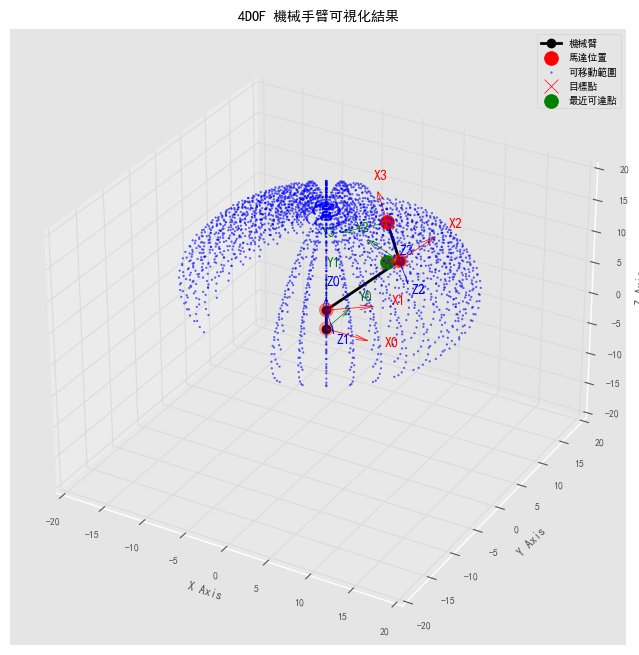

In [3]:
#-----------------------------------------------------------------
# ROBOT_ARM_RK.py
# input (x) (y) (z)
# 讀取 'joint_angles.npy' 和 'reachable_points.npy'
# 顯示手臂可視化界面
# **已經做好校正**
#-----------------------------------------------------------------  

import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
from spatialmath import SE3
import matplotlib

# 設定 Matplotlib 使用黑體（SimHei）
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 黑體
matplotlib.rcParams['axes.unicode_minus'] = False  # 正確顯示負號

# 設定 DH 參數
link1 = rtb.RevoluteDH(a=0, alpha=np.pi/2, d=3)
link2 = rtb.RevoluteDH(a=10.4, alpha=0, d=0)
link3 = rtb.RevoluteDH(a=6.35, alpha=0, d=0)
robot = rtb.DHRobot([link1, link2, link3], name= "3DOF Robot Arm")

# 校正馬達角度
""" 預設馬達角度 [100, 95, 95] """
""" 手臂校正角度 [0, 90, 0] """
offsetd = [100, 5, 95]
offset = np.radians(offsetd)

# 讀取.npy數據
joint_angles = np.load("joint_angles.npy")
reachable_points = np.load("reachable_points.npy")

def find_nearest_reachable_point(target):
    """
    透過 MSE 計算找到機械手臂可達範圍內最近的點（僅以 X, Y 計算誤差），並強制使最佳解的 Z 值與目標 Z 值一致
    """
    # 只取 x, y 兩個維度計算 MSE
    mse_values = np.sum((reachable_points[:, :2] - target[:2]) ** 2, axis=1)
    index = np.argmin(mse_values)
    best_point = reachable_points[index].copy()
    
    # 強制最佳解的 z 軸高度與輸入 z 軸高度相同
    best_point[2] = target[2]
    
    best_angles = np.radians(joint_angles[index]) * np.array([1, 1, -1]) + offset
    
    # 計算與輸入目標的誤差（僅針對 x, y）
    error_xy = best_point[:2] - target[:2]
    error_z = 0.0
    error = np.array([error_xy[0], error_xy[1], error_z])
    print(f"最佳解座標: X = {best_point[0]:.2f}, Y = {best_point[1]:.2f}, Z = {best_point[2]:.2f}, MSE (X, Y) = {mse_values[index]:.6f}")
    print(f"誤差: ΔX = {error_xy[0]:.2f}, ΔY = {error_xy[1]:.2f}, ΔZ = {error_z:.2f}")
    
    return best_point, best_angles, error

def generate_movement_grid():
    """ 從已計算的檔案中選擇每個馬達角度皆為 10 的倍數的座標 """
    valid_indices = [i for i, angles in enumerate(joint_angles) if all(angle % 10 == 0 for angle in angles)]
    return reachable_points[valid_indices]

def plot_robot(q, target_point=None, adjusted_point=None):
    """ 繪製 3D 機械手臂視覺化圖，並顯示馬達的關節點 """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 計算機械手臂關節位置
    T0 = SE3()
    T1 = T0 @ robot.links[0].A(q[0])
    T2 = T1 @ robot.links[1].A(q[1])
    T3 = T2 @ robot.links[2].A(q[2])

    # 取得所有關節位置
    joints = np.array([T0.t, T1.t, T2.t, T3.t])

    # 繪製機械手臂連接線
    ax.plot(joints[:, 0], joints[:, 1], joints[:, 2], marker='o', markersize=6, linestyle="-", linewidth=2, color="black", label="機械臂")

    # 繪製關節點（馬達）
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], c='r', marker='o', s=100, label="馬達位置")

    # 繪製每個關節的局部座標軸
    transforms = [T0, T1, T2, T3]
    colors = ['r', 'g', 'b']
    axis_labels = ['X', 'Y', 'Z']

    for i, T in enumerate(transforms):
        origin = T.t
        R = T.R
        """局部坐標軸 X Y Z 大小&位置設定 """
        for j in range(3):  # X, Y, Z 軸
            ax.quiver(origin[0], origin[1], origin[2], 
                      R[0, j], R[1, j], R[2, j], 
                      color=colors[j], length=5, normalize=True)
            
            # 在箭頭尖端標示 X, Y, Z
            labels_length = 7
            ax.text(origin[0] + R[0, j] * labels_length, origin[1] + R[1, j] * labels_length, origin[2] + R[2, j] * labels_length, 
                    f'{axis_labels[j]}{i}', color=colors[j], fontsize=10, weight='bold')

    # 顯示可移動範圍的點
    movement_points = generate_movement_grid()
    ax.scatter(movement_points[:, 0], movement_points[:, 1], movement_points[:, 2], c='b', marker='.', s=5, alpha=0.5, label="可移動範圍")

    # 標示輸入目標點
    if target_point is not None:
        ax.scatter(target_point[0], target_point[1], target_point[2], c='r', marker='x', s=100, label="目標點")

    # 標示找到的最近可達點
    if adjusted_point is not None:
        ax.scatter(adjusted_point[0], adjusted_point[1], adjusted_point[2], c='g', marker='o', s=100, label="最近可達點")

    # 設定圖表範圍
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-20, 20])
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("4DOF 機械手臂可視化結果")
    ax.legend()
    plt.show()

    
# 逆向運動學模式
x = float(input("輸入目標 X 座標 (cm): "))
print(f"你輸入的 X 座標: {x}")
y = float(input("輸入目標 Y 座標 (cm): "))
print(f"你輸入的 Y 座標: {y}")
z = float(input("輸入目標 Z 座標 (cm): 最高19.75 (cm)"))
print(f"你輸入的 Z 座標: {z}")

target_point = np.array([x, y, z])
adjusted_point, q_sol, error = find_nearest_reachable_point(target_point)
print(f"最佳解關節角度: theta1 = {np.degrees(q_sol[0]):.2f}, theta2 = {np.degrees(q_sol[1]):.2f}, theta3 = {np.degrees(q_sol[2]):.2f}")

plot_robot((q_sol - offset) * np.array([1, 1, -1]), target_point=target_point, adjusted_point=adjusted_point)

In [ ]:
import openai  # OpenAI Whisper API 客戶端
import pyaudio  # 用於錄音
import wave  # 存儲 WAV 文件
import os  # 文件操作
import tempfile  # 創建臨時目錄
from pydub import AudioSegment  # 轉換音訊格式
from pydub.utils import which  # 確保 FFmpeg 可用
import time #延遲動作

# 設置 OpenAI API 客戶端
client = openai.OpenAI(api_key = "")

################################# .wav錄製 ##########################

# 錄音參數
FORMAT = pyaudio.paInt16  # 16-bit PCM
CHANNELS = 1  # 單聲道
RATE = 44100  # 取樣率
CHUNK = 1024  # 每次讀取 1024 字節
RECORD_SECONDS = 5  # 錄音時長（秒）
OUTPUT_WAV_FILENAME = "output.wav"  # 暫存 WAV
OUTPUT_MP3_FILENAME = "output.mp3"  # 轉 MP3

def record_audio():
    """ 錄製音訊並存儲為 WAV 文件 """
    audio = pyaudio.PyAudio()
    print(" 開始錄音... ")

    stream = audio.open(format=FORMAT, channels=CHANNELS,
                        rate=RATE, input=True, frames_per_buffer=CHUNK)

    frames = []
    try:
        for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
            data = stream.read(CHUNK)
            frames.append(data)
    except Exception as e:
        print(f" 錄音錯誤: {e} ")
    finally:
        print(" 錄音結束. ")
        stream.stop_stream()
        stream.close()
        audio.terminate()

        with wave.open(OUTPUT_WAV_FILENAME, 'wb') as wf:
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(audio.get_sample_size(FORMAT))
            wf.setframerate(RATE)
            wf.writeframes(b''.join(frames))

        if os.path.exists(OUTPUT_WAV_FILENAME):
            print(f" 錄音完成: {OUTPUT_WAV_FILENAME} ")
        else:
            print(" 錄音失敗! ")

############################## .wav轉.mp3 ########################################

def convert_wav_to_mp3():
    """將 WAV 轉換為 MP3"""
    if not os.path.exists(OUTPUT_WAV_FILENAME):
        print(f" 找不到 {OUTPUT_WAV_FILENAME}，無法轉換! ")
        return

    print(f" 轉換 {OUTPUT_WAV_FILENAME} 至 {OUTPUT_MP3_FILENAME} ")
    try:
        audio = AudioSegment.from_wav(OUTPUT_WAV_FILENAME)
        audio.export(OUTPUT_MP3_FILENAME, format="mp3")
        print(f" 轉換完成: {OUTPUT_MP3_FILENAME} ")

        os.remove(OUTPUT_WAV_FILENAME)
        print(" 刪除臨時 WAV 文件. ")
    except Exception as e:
        print(f" MP3 轉換失敗: {e} ")

def transcribe_audio_with_whisper(audio_file_path):
    
    """ 使用 Whisper API 轉錄音訊文件（中文）。 """
    
    with open(audio_file_path, "rb") as audio_file:
        response = client.audio.transcriptions.create(
            model="whisper-1",
            file=audio_file,
            language="zh"  # 強制識別中文
        )
        return response.text  # 返回轉錄內容

def split_and_transcribe_audio(file_path, segment_length_seconds=30):    
    
    """ 將音訊文件切割為小片段，並使用 Whisper API 轉錄，儲存至變數instruction。 """
    
    try:
        song = AudioSegment.from_file(file_path)
    except Exception as e:
        raise Exception(f" 無法讀取音訊文件: {e} ")

    segment_length_ms = segment_length_seconds * 1000
    transcripts = []

    with tempfile.TemporaryDirectory() as temp_dir:
        for i, segment in enumerate([song[i:i+segment_length_ms] for i in range(0, len(song), segment_length_ms)]):
            segment_file_path = os.path.join(temp_dir, f"segment_{i}.mp3")
            segment.export(segment_file_path, format="mp3")

            try:
                transcript = transcribe_audio_with_whisper(segment_file_path)
            except Exception as e:
                transcript = f" 轉錄失敗: {e} "

            transcripts.append(transcript)

    instruction = "\n".join(transcripts)  # 儲存為變數
    print(" 轉錄完成! ")
    
    return instruction  # 回傳轉錄的內容

# 執行錄音 → 轉 MP3 → Whisper 轉錄
record_audio()
convert_wav_to_mp3()
instruction = split_and_transcribe_audio(OUTPUT_MP3_FILENAME)

############################## AMMR 與 ACTION_SPACE定義 #############################

class AMMR:
    def __init__(self, robot_id):
        self.robot_id = robot_id

    def stop(self):
        print(f"AMMR({self.robot_id}) stopping.")

    def forward(self, distance):
        print(f"AMMR({self.robot_id}) moving forward {distance} (cm)")

    def right(self):
        print(f"AMMR({self.robot_id}) turning right.")

    def left(self):
        print(f"AMMR({self.robot_id}) turning left.")
        
    def turn(self, angle):
        print(f"AMMR({self.robot_id}) turning {angle} (degrees)")

    def pick(self):
        print(f"AMMR({self.robot_id}) picking up an object.")

############################# LLM決策分析 ####################################

def execute_commands(response_message):
    robots = {}
    commands = response_message.strip().split("\n")

    for command in commands:
        parts = command.split(", ")
        if len(parts) != 2:
            continue  # 忽略格式錯誤的行

        robot_part, action_part = parts
        robot_id = int(robot_part.split("(")[1].split(")")[0])

        # 初始化機器人對象
        if robot_id not in robots:
            robots[robot_id] = AMMR(robot_id)

        # 解析動作
        if action_part.startswith("forward"):
            distance = float(action_part.split("(")[1].split(")")[0])
            robots[robot_id].forward(distance)
        elif action_part == "stop":
            robots[robot_id].stop()
        elif action_part == "right":
            robots[robot_id].right()
        elif action_part == "left":
            robots[robot_id].left()
        elif action_part.startswith("turn"):
            angle = float(action_part.split("(")[1].split(")")[0])
            robots[robot_id].turn(angle)
        elif action_part == "pick":
            robots[robot_id].pick()

        time.sleep(0.5)  # 模擬動作延遲
        
###############################LLM決策生成#####################################


environment_state = """環境: 
地圖:(0,0)到(50,50)方格。
載具:AMMR(1)位於(5,5) AMMR(2)位於(35,5)
物品:可樂位於(5,40)，餅乾位於(35,40)，人(0,0)"""

# 將 `instruction` 內容加入 Chat API
chat_completion = client.chat.completions.create(
    messages=[
        {
          "role":"system","content":"你是一個用於控制雙載具分別為AMMR(1)，AMMR(2)的機器人，利用下列環境與指令資訊\
                                        分別輸出一系列排程1.2.3.4.等等步驟。並一開始輸出對自身決策的可信度0~1\
                                        車輛動作:{stop, #使車輛停止                  \
                                        forward(),     #使車輛向前進該單位          \
                                        turn(),        #使車輛向左轉該角度           \
                                        pick1,         #使車輛上的夾爪夾起高處物品   \
                                        pick2,         #使車輛上的夾爪夾起低處物品   \
                                        place1,        #使車輛上的夾爪放下物品至高處 \
                                        place2,        #使車輛上的夾爪放下物品至低處 \
                                        ide}           #使車輛待機                 \
                                        例如\
                                            0.64 \
                                            1. AMMR(1), forward(10) \
                                            2. AMMR(2), ide\
                                            3. AMMR(1), turn(60) \
                                            4. AMMR(2), ide\
                                            5. AMMR(1), pick1 \
                                            6. AMMR(2), ide \
                                            可信度分數:0.64 \
                                            AMMR1向前10(cm)，AMMR1向左轉60度、AMMR1夾起高處物品\
                                            且不要輸出排程跟可信度以外的敘述，且盡量交叉不同車輛動作，使其同步進行\
                                            不要出現範例程式碼、跟可信度以外的文字 \
                                            請檢查自己的輸出步驟是否有漏\
                                            若指令與決策無關則回傳none\
                                            "
        },
        {
            "role": "user",
            "content": f"{environment_state}\
                指令: {instruction}"  # 這裡加入 `instruction`
        }
    ],
    model="gpt-4o"
)

# 輸出結果
response_message = chat_completion.choices[0].message.content
print(f"\n人類要求: {instruction}\n")

# print("LLM回應:\n")
# print(response_message)

execute_commands(response_message)